In [1]:
import os
import random
import time
import cv2
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from keras.callbacks import EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Tensorflow Hub
import tensorflow_hub as hub
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

In [ ]:
!unzip waste_classification_data_v2.zip

In [4]:
data_dir = os.path.join("./waste_classification_data_v2/DATASET","TRAIN")
label_names = os.listdir( data_dir)
num_classes = len(label_names)

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

Number of classes: 3
Labels: ['N', 'O', 'R']


In [5]:
# Generate a list of labels and path to text
data_x = []
data_y = []
sample_images = {}

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])
  sample_images[label] = random.sample(text_files, 4) 

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

data_x count: 22564
data_y count: 22564
['./waste_classification_data_v2/DATASET/TRAIN/N/R_821.jpg', './waste_classification_data_v2/DATASET/TRAIN/N/R_415.jpg', './waste_classification_data_v2/DATASET/TRAIN/N/R_217.jpg', './waste_classification_data_v2/DATASET/TRAIN/N/R_2444.jpg', './waste_classification_data_v2/DATASET/TRAIN/N/R_263.jpg']
['N', 'N', 'N', 'N', 'N']


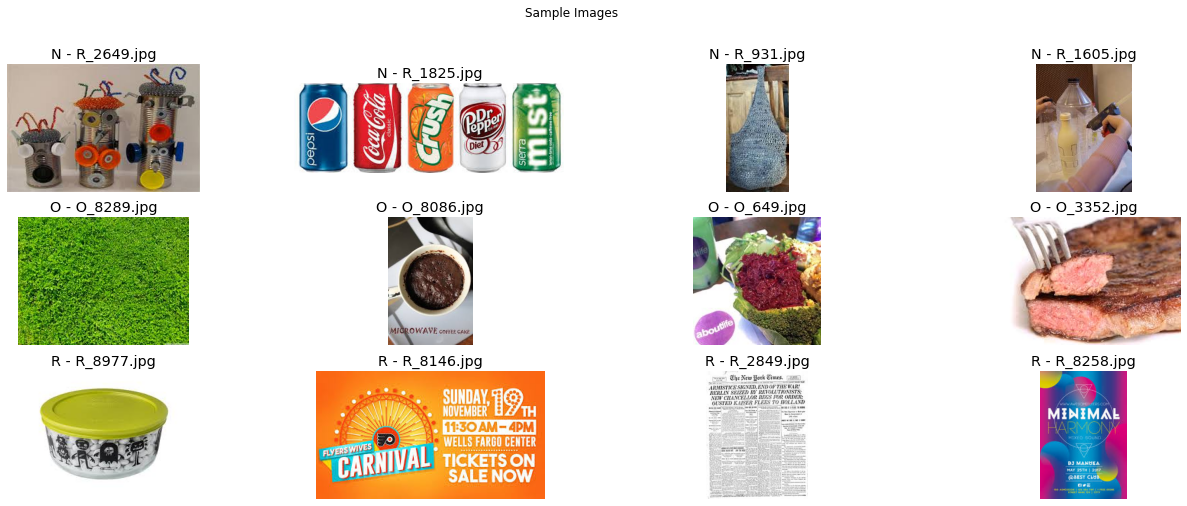

In [6]:
# Display a sample of each class type
fig = plt.figure(figsize=(20,8))

img_pos = 1
for label in sample_images:
    for file in sample_images[label]:
        axs = fig.add_subplot(num_classes,4,img_pos)
        axs.set_title(f"{label} - {file}")
        image = cv2.imread(os.path.join(data_dir,label,file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        img_pos += 1

plt.suptitle("Sample Images")
plt.show()

## Prepare test set

In [7]:
data_dir_test = os.path.join("./waste_classification_data_v2/DATASET","TEST")
label_names = os.listdir(data_dir_test)
num_classes = len(label_names)

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)


# Generate a list of labels and path to text
test_data_x = []
test_data_y = []
sample_images = {}

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir_test,label))
  test_data_x.extend([os.path.join(data_dir_test,label,f) for f in text_files])
  test_data_y.extend([label for f in text_files])
  sample_images[label] = random.sample(text_files, 4) 

# Preview
print("test_data_x count:",len(test_data_x))
print("test_data_y count:",len(test_data_y))
print(test_data_x[:5])
print(test_data_y[:5])

Number of classes: 3
Labels: ['N', 'O', 'R']
test_data_x count: 2910
test_data_y count: 2910
['./waste_classification_data_v2/DATASET/TEST/N/00000139.png', './waste_classification_data_v2/DATASET/TEST/N/00000042.jpg', './waste_classification_data_v2/DATASET/TEST/N/00000127.jpg', './waste_classification_data_v2/DATASET/TEST/N/00000349.jpg', './waste_classification_data_v2/DATASET/TEST/N/00000129.jpg']
['N', 'N', 'N', 'N', 'N']


## Build Data Pipeline

In [8]:
validation_percent = 0.1

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_data_x count:",len(test_data_x))

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_data_y]

train_x count: 20307
validate_x count: 2257
test_data_x count: 2910


In [27]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64 #32
num_classes = 3

train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_data_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_data_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
test_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>


In [10]:
# Create an experiment
create_experiment()

# Variable to switch to tutorial mode so pre-trained models are loaded and continued on training
LOAD_PREV_TRAINED = False

In [22]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        tranfer_model_base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(units=128, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='mobilenetv2_train_base_'+str(train_base))

  return model

In [23]:
############################
# Training Params
############################
learning_rate = 0.01
initial_epoch = 0
epochs = 3

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = True)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=['accuracy'])
else:
  # Load model
  model_name = "mobilenetv2_train_base_True"
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5")
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

Model: "mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 2,388,227
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/3
318/318 [==============================] - 98s 299ms/step - loss: 38.1844 - accuracy: 0.8624 - val_loss: 1.9983 - val_accuracy: 0.8706
Epoch 2/3
318/318 [==============================] - 95s 298ms/step - lo

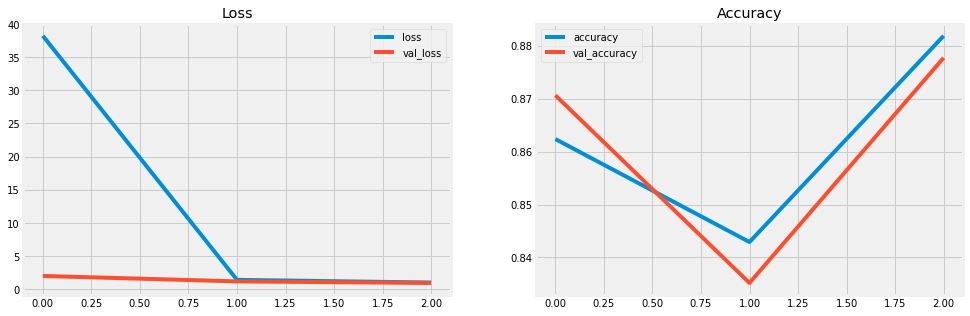

 4/46 [=>............................] - ETA: 2s - loss: 1.7989 - accuracy: 0.4414

InvalidArgumentError: ignored

In [28]:
evaluate_save_model(model, test_data, training_history, execution_time, learning_rate, batch_size, epochs, optimizer, save=False)